In [1]:
import cv2
import math
import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt

#Assumption
Zmin = 0
Zmax = 255

In [2]:
def ReadImages():
    open_input = open('input.txt')
    imagefiles = []
    times = []
    for img in open_input:
        if img[0] =='#':
            continue
        (imagename, time) = img.split()
        imagefiles += [imagename]
        times += [time]
    images = [cv2.imread(i) for i in imagefiles]
    
    alignMTB = cv2.createAlignMTB()
    alignMTB.process(images, images)
    
    images = np.array(images)
    times = np.array(times, dtype = np.float32)
    open_input.close()
    
    return images, times


In [3]:
def Debevec(images, lnt):
    sampimg = [cv2.resize(img, (10, 10)) for img in images]
    Z = [img.flatten() for img in sampimg]
    Z = np.array(Z)
    B = lnt
    l = 10
    w = [i if i <= 0.5 * 255 else 255 - i for i in range(256)]
    
    return RecoverResponseFunction(Z, B, l, w)
    

In [4]:
def RecoverResponseFunction(Z, B, l, w):
    n = 256
    A = np.zeros((Z.shape[0] * Z.shape[1] + n + 1, Z.shape[1] + n), dtype = np.float32)
    b = np.zeros((A.shape[0], 1), dtype = np.float32)
    
    #Include the data-fitting equations
    k = 0
    for i in range(Z.shape[1]):
        for j in range(Z.shape[0]):
            wij = w[Z[j, i]]
            A[k, Z[j, i]] = wij
            A[k, n + i]   = -wij
            b[k, 0]       = wij * B[j]
            k = k + 1
            
    #Set middle value to 0 to fix the curve
    A[k, n // 2] = 1
    k = k + 1
    
    #Include the smoothless equations
    for i in range(n - 1):
        A[k, i]     =      l * w[i + 1]
        A[k, i + 1] = -2 * l * w[i + 1]
        A[k, i + 2] =      l * w[i + 1]
        k = k + 1
    
    #Solve the system using SVD
    x  = np.dot(np.linalg.pinv(A), b)
    g  = x[:n, 0]
    lE = x[n:, 0]
    
    return g, lE, Z


In [5]:
def HDR(images, lnt):
    shp = images[...,].shape
    hdr = np.zeros(shp[1:], dtype = np.float32)
    for i in range(shp[3]):
        img = images[:, :, :, i]
        RC, lE, Z = Debevec(images, lnt)
        radmap = RadiantMap(img, lnt, RC)
        hdr[..., i] = cv2.normalize(radmap, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
    return hdr
        

In [6]:
def RadiantMap(images, lnt, RC):
    shp = images.shape
    radmap = np.zeros(shp[1:], dtype = np.float32)
    wt = np.zeros(shp, dtype = np.float32)
    for i in range(shp[1]):
        for j in range(shp[2]):
            wt[:, i, j] = lnt
    imageslength = len(images)
    g = RC[images]
    we = weight(images)
    wsum = np.sum(we, axis = 0)
    radmap = np.sum(we * (g - wt) / wsum, axis = 0)
    for i in range(shp[1]):
        for j in range(shp[2]):
            if np.isnan(radmap[i][j]):
                radmap[i][j] = g[imageslength // 2][i][j] - lnt[imageslength // 2][i][j]
    return np.exp(radmap)

In [7]:
def weight(v):
    u = abs(v - 0.5 * 255) / 128
    u = -(u - 0 * 255) / 128
    return u

In [8]:
def ToneMapping(hdr):
    tonemapDrago = cv2.createTonemapDrago(1.0, 1.0, 0.9)
    ldrDrago = tonemapDrago.process(hdr)
    for i in range(1, 10):
        cv2.imwrite(str(i) + "Result_Drago.jpg", (i * ldrDrago * 255))
    return

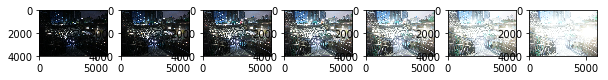

In [9]:
imgtest, timtest = ReadImages()
logtimtest = np.log2(timtest)
imglength = len(imgtest)
channels = imgtest.shape[3]
chlength = range(channels)

plt.figure(figsize = (10, 20))
for i in range(imglength):
    imgplt = plt.subplot(imglength, imglength, i + 1)
    imgplt.imshow(imgtest[i])
    
w = [i if i <= 0.5 * 255 else 255 - i for i in range(256)]
w = np.array(w)

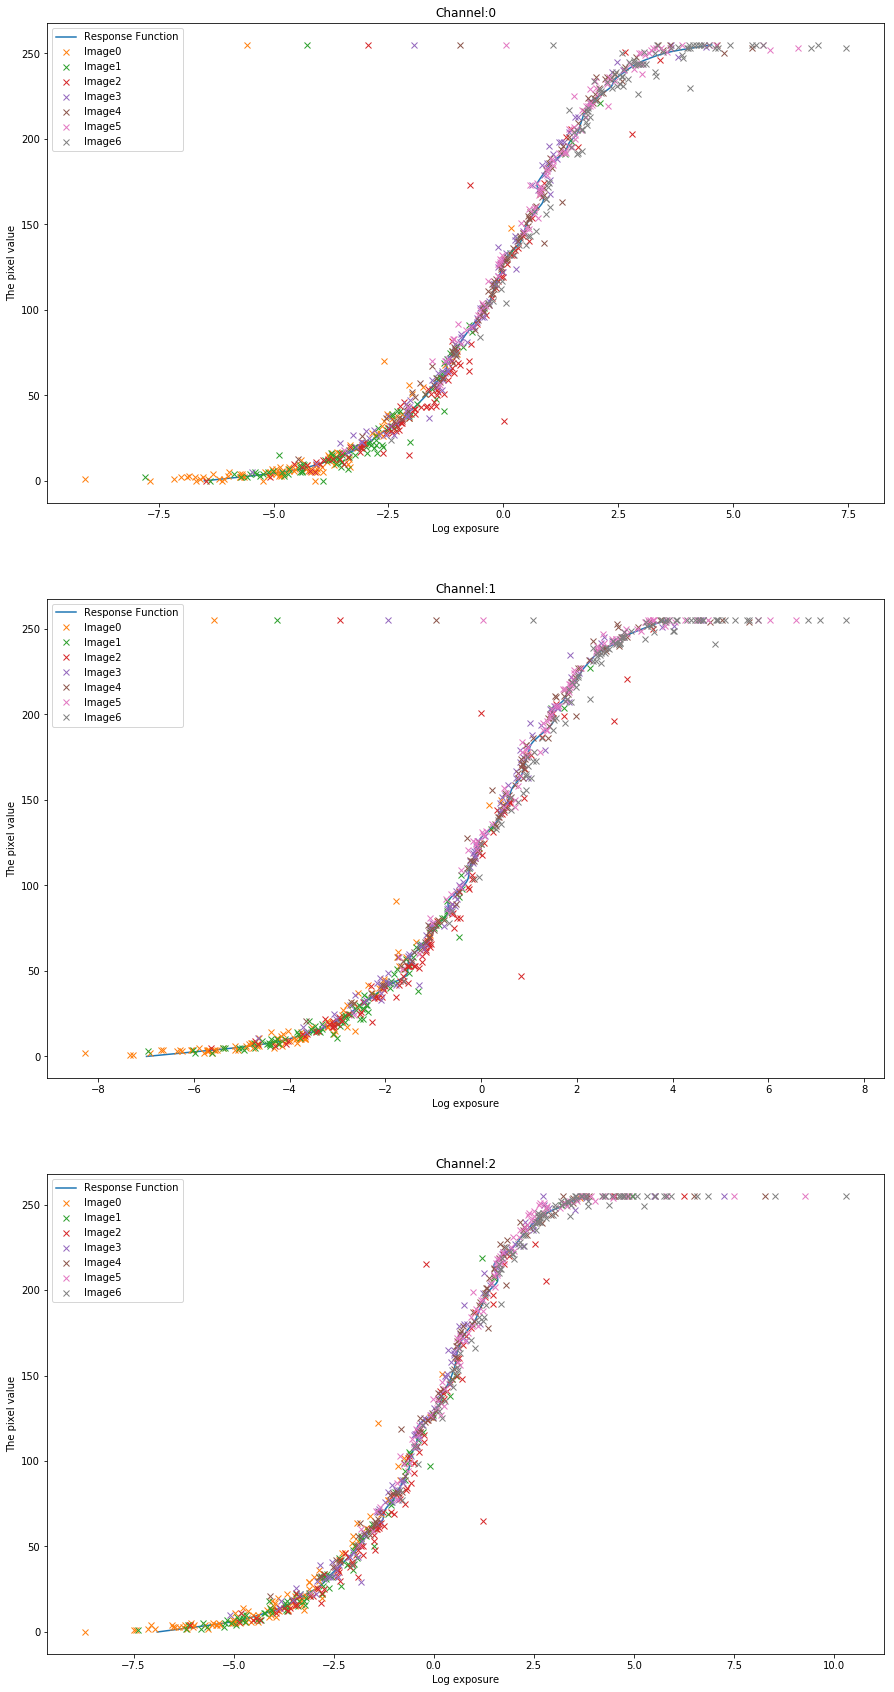

In [10]:
result = np.zeros(imgtest[0].shape)
plt.figure(figsize = (15, 30))
for channel in chlength:
    chimg = imgtest[:, :, :, channel]
    ResponseFunction, lE, Z = Debevec(chimg, logtimtest)
    imgplt = plt.subplot(channels, 1, channel + 1)
    imgplt.plot(ResponseFunction, range(ResponseFunction.shape[0]), label = 'Response Function')
    plt.ylabel('The pixel value')
    plt.xlabel('Log exposure')
    for i in range(imglength):
        plt.plot(lE + logtimtest[i], Z[i, :], 'x', label = 'Image' + str(i))
    imgplt.legend()
    imgplt.set_title("Channel:" + str(channel))

In [11]:
hdr = HDR(imgtest, logtimtest)

In [12]:
#Save HDR (https://gist.github.com/edouardp/3089602)
rhdr = np.zeros((hdr.shape[0], hdr.shape[1], 3), 'float32')
rhdr[..., 0] = hdr[..., 2]
rhdr[..., 1] = hdr[..., 1]
rhdr[..., 2] = hdr[..., 0]

f = open("Result.hdr", 'wb')
f.write(bytes(("#?RADIANCE\n# Made with Python & Numpy\nFORMAT=32-bit_rle_rgbe\n\n"), encoding = 'utf-8'))
header = '-Y {0} +X {1}\n'.format(rhdr.shape[0], rhdr.shape[1]) 
f.write(bytes(header, encoding='utf-8'))

brightest = np.maximum(np.maximum(rhdr[...,0], rhdr[...,1]), rhdr[...,2])
mantissa = np.zeros_like(brightest)
exponent = np.zeros_like(brightest)
np.frexp(brightest, mantissa, exponent)
scaled_mantissa = mantissa * 256.0 / brightest
rgbe = np.zeros((rhdr.shape[0], rhdr.shape[1], 4), dtype=np.uint8)
rgbe[...,0:3] = np.around(rhdr[...,0:3] * scaled_mantissa[...,None])
rgbe[..., 3] = np.around(exponent + 128)

rgbe.flatten().tofile(f)
f.close()

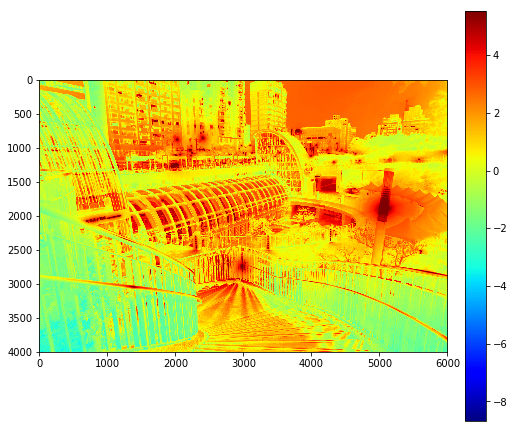

In [13]:
# Show false-color Radiance map
plt.figure(figsize = (8, 16))
plt.imshow(np.log(cv2.cvtColor(hdr, cv2.COLOR_BGR2GRAY)), cmap = 'jet')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [14]:
ToneMapping(hdr)